# Prototipo simulador parte 1: Modelo de la mecánica pulmonar

In [1]:
# Librerías
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Estilo
plt.style.use('seaborn-v0_8-whitegrid')

En cumplimiento del primer objetivo, se establecieron cuáles eran los modelos que se iban a implementar en este módulo. Este primer prototipo será el MVP, un prototipo funcional que sólo implementa el módulo mecánico, sobre el cual se iterará para implementar los siguientes modelos.

## El modelo a implementar

Como se detalla en el documento del trabajo de grado, durante el desarrollo del objetivo 1 se definió implementar como módulo mecánico el modelo de dos compartimientos en paralelo. Las ecuaciones que lo describen son:

$ P_{aw} (t) = E_1 V_1(t) + R_1 \dot{V}_1 (t) = E_2 V_2(t) + R_2 \dot{V}_2 (t)$  
$ V_{total} = V_1(t) + V_2(t)$  
$ \dot{V}_{total} (t) = \dot{V}_1 + \dot{V}_2 $

In [2]:
def modelo_dos_compartimentos(t, y, P_aw_func, R1, E1, R2, E2):
    """
    Define el sistema de EDOs para el modelo de dos compartimentos.

    Argumentos:
    t: tiempo actual
    y: arreglo con los valores actuales de las variables de estado [V1, V2].
    P_aw_func: una función que devuelve la presión aplicada (Paw) en el tiempo t.
    R1, E1, R2, E2: parámetros de resistencia y elastancia de los compartimentos.

    Retorna:
    Una lista con las derivadas de cada variable de estado: [dV1/dt, dV2/dt].
    """
    V1, V2 = y
    P_aw = P_aw_func(t)

    # Ecuaciones diferenciales del modelo, reorganizadas para dV/dt
    # dV1/dt = (P_aw - E1 * V1) / R1
    # dV2/dt = (P_aw - E2 * V2) / R2

    dV1_dt = (P_aw - E1 * V1) / R1
    dV2_dt = (P_aw - E2 * V2) / R2

    return [dV1_dt, dV2_dt]

## Modelo de dos compartimientos en PCV

Para este MVP, se va a simular una ventilación controlada por presión (PCV), porque es la más simple de modelar (onda de presión cuadrada). Se configuran unos parámetros genéricos de un paciente simulado:

In [3]:
# --- PARÁMETROS DEL PACIENTE SIMULADO ---
R1 = 5      # Resistencia del compartimento 1 (cmH2O/L/s)
C1 = 0.05   # Compliancia del compartimento 1 (L/cmH2O)
E1 = 1 / C1 # Elastancia del compartimento 1

R2 = 10     # Resistencia del compartimento 2 (más alta)
C2 = 0.03   # Compliancia del compartimento 2 (más baja)
E2 = 1 / C2 # Elastancia del compartimento 2

# --- PARÁMETROS DEL VENTILADOR (MODO PCV) ---
PEEP = 5.0          # Presión Positiva al Final de la Espiración (cmH2O)
P_driving = 15.0      # Presión de conducción por encima de PEEP (cmH2O)
P_control = PEEP + P_driving # Presión control total
T_insp = 1.0        # Tiempo inspiratorio (s)
T_total = 3.0       # Duración total del ciclo respiratorio (frecuencia = 20/min)

# --- FUNCIÓN DE ENTRADA (PRESIÓN) ---
# Define la onda cuadrada de presión para el modo PCV
def presion_pcv(t):
    """
    Calcula la presión aplicada para un tiempo o arreglo de tiempos t.
    """
    # np.where(condición, valor_si_verdadero, valor_si_falso)
    return np.where(t < T_insp, P_control, PEEP)

Teniendo ya definidos el modelo y unos parámetros simulados para el primer prototipo, se resuelven las ecuaciones con ´solve_ivp´de SciPy:

In [4]:
# Condiciones iniciales: El ciclo empieza con los pulmones en PEEP, sin volumen adicional.
V_inicial = [0, 0]

# Tiempo a simular
t_span = [0, T_total]
# Puntos de tiempo donde queremos la solución (para graficar)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solución del sistema de EDOs.
solucion = solve_ivp(
    fun=modelo_dos_compartimentos,
    t_span=t_span,
    y0=V_inicial,
    t_eval=t_eval,
    args=(presion_pcv, R1, E1, R2, E2),
    dense_output=True # Nos permite calcular la solución en cualquier punto
)

Se toman los datos de la solución y se grafican para verlos/entenderlos:

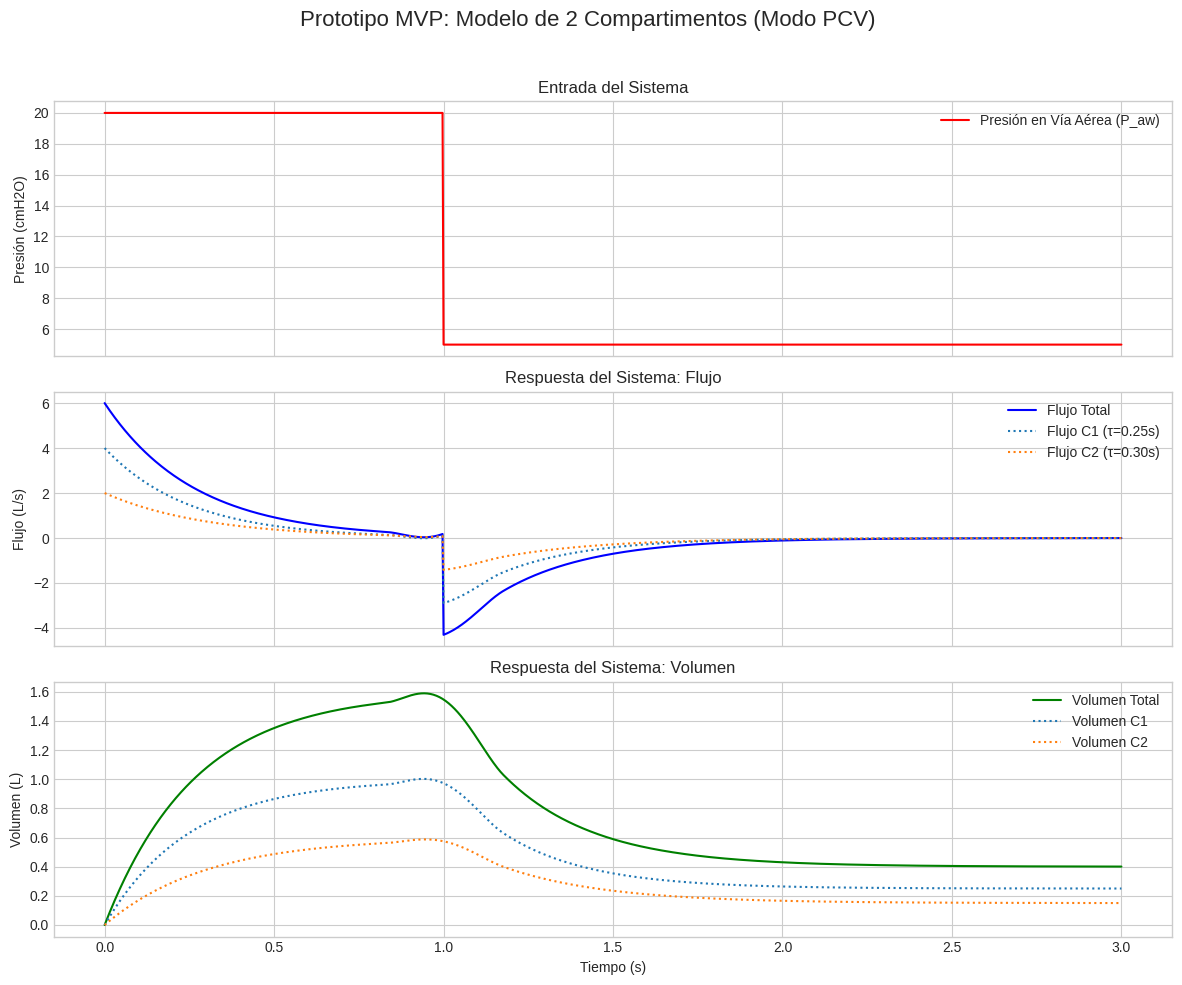

In [5]:
# --- PROCESAMIENTO DE RESULTADOS ---
# Extraer volúmenes de la solución
V1 = solucion.y[0]
V2 = solucion.y[1]
V_total = V1 + V2

# Calcular flujos usando la función del modelo.
# Ahora podemos pasar t_eval directamente porque presion_pcv es vectorizada.
flujo1, flujo2 = modelo_dos_compartimentos(t_eval, solucion.y, presion_pcv, R1, E1, R2, E2)
flujo_total = np.array(flujo1) + np.array(flujo2)

# Obtener la curva de presión es ahora más simple y eficiente
P_aplicada = presion_pcv(t_eval)

# --- VISUALIZACIÓN ---
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Prototipo MVP: Modelo de 2 Compartimentos (Modo PCV)', fontsize=16)

# 1. Gráfica de Presión
axs[0].plot(t_eval, P_aplicada, label='Presión en Vía Aérea (P_aw)', color='red')
axs[0].set_ylabel('Presión (cmH2O)')
axs[0].legend()
axs[0].set_title('Entrada del Sistema')

# 2. Gráfica de Flujo
axs[1].plot(t_eval, flujo_total, label='Flujo Total', color='blue')
axs[1].plot(t_eval, flujo1, label=f'Flujo C1 (τ={R1*C1:.2f}s)', linestyle=':')
axs[1].plot(t_eval, flujo2, label=f'Flujo C2 (τ={R2*C2:.2f}s)', linestyle=':')
axs[1].set_ylabel('Flujo (L/s)')
axs[1].legend()
axs[1].set_title('Respuesta del Sistema: Flujo')

# 3. Gráfica de Volumen
axs[2].plot(t_eval, V_total, label='Volumen Total', color='green')
axs[2].plot(t_eval, V1, label='Volumen C1', linestyle=':')
axs[2].plot(t_eval, V2, label='Volumen C2', linestyle=':')
axs[2].set_ylabel('Volumen (L)')
axs[2].set_xlabel('Tiempo (s)')
axs[2].legend()
axs[2].set_title('Respuesta del Sistema: Volumen')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Simulando VCV

Se obtiene una gráfica que refleja de manera aproximada el comportamiento de un paciente real. Teniendo ya este modelo funcional (este primer MVP), se procede a iterar para evaluar cómo este modulo mecánico, responde a diferentes entradas. Se procede a iterar con Ventilación controlada por volumen.

En PCV, se generaba una presión constante y el flujo resultante era una consecuencia (exponencial decreciente).  
En VCV, se genera un flujo inspiratorio constante y la presión resultante es la consecuencia. La presión en la vía aérea debería aumentar en la medida en que se llene el pulmón para vencer las resistencias y la elastancia del sistema.  
Entonces, en lugar de presión de conducción (*driving pressure*, definida como `P_driving`), se define un volumen corriente objetivo (el `volumen_tidal_objetivo`:

In [6]:
# --- PARÁMETROS DEL VENTILADOR (MODO VCV) ---
volumen_tidal_objetivo = 0.5  # L
T_insp_vcv = 1.0              # Tiempo inspiratorio (s)
T_total_vcv = 3.0             # Duración total del ciclo (misma frecuencia de 20/min)
PEEP_vcv = 5.0                # Usaremos la misma PEEP

# En VCV con flujo constante, el flujo es el volumen dividido por el tiempo
flujo_inspiratorio_constante = volumen_tidal_objetivo / T_insp_vcv

Hay que definir una nueva función para el modelo, porque la lógica de entrada y de salida cambia:

In [7]:
def modelo_vcv(t, y, flujo_insp, T_insp, PEEP, R1, E1, R2, E2):
    """
    Define el sistema de EDOs para el modo VCV.
    Durante la inspiración, el flujo total es constante.
    Durante la espiración, la presión es constante (PEEP).
    """
    V1, V2 = y

    """if t < T_insp:
        # FASE INSPIRATORIA (Flujo constante)
        # Primero, calculamos la P_aw necesaria para generar el flujo constante
        # dado el estado actual de V1 y V2.
        numerador = flujo_insp + (E1 * V1 / R1) + (E2 * V2 / R2)
        denominador = (1 / R1) + (1 / R2)
        P_aw = numerador / denominador

        # Ahora, con esa P_aw, calculamos el flujo de cada compartimento
        dV1_dt = (P_aw - E1 * V1) / R1
        dV2_dt = (P_aw - E2 * V2) / R2

    else:
        # FASE ESPIRATORIA (Presión constante = PEEP)
        # La lógica es idéntica a la espiración en PCV
        P_aw = PEEP
        dV1_dt = (P_aw - E1 * V1) / R1
        dV2_dt = (P_aw - E2 * V2) / R2 """

    # ---- Lógica Inspiratoria Vectorizada ----
    numerador_insp = flujo_insp + (E1 * V1 / R1) + (E2 * V2 / R2)
    denominador_insp = (1 / R1) + (1 / R2)
    P_aw_insp = numerador_insp / denominador_insp
    dV1_dt_insp = (P_aw_insp - E1 * V1) / R1
    dV2_dt_insp = (P_aw_insp - E2 * V2) / R2

    # ---- Lógica Espiratoria Vectorizada ----
    P_aw_esp = PEEP
    """dV1_dt_esp = (P_aw_esp - E1 * V1) / R1
    dV2_dt_esp = (P_aw_esp - E2 * V2) / R2"""
    dV1_dt_esp = (-E1 * V1) / R1
    dV2_dt_esp = (-E2 * V2) / R2

    # ---- Combinar usando np.where ----
    es_inspiracion = t < T_insp
    dV1_dt = np.where(es_inspiracion, dV1_dt_insp, dV1_dt_esp)
    dV2_dt = np.where(es_inspiracion, dV2_dt_insp, dV2_dt_esp)

    return [dV1_dt, dV2_dt]

Se llama de nuevo `solve_ivp`, pero con  la función y los parámetros de VCV:

In [8]:
# --- EJECUCIÓN DE LA SIMULACIÓN VCV ---

# Condiciones iniciales y tiempo de evaluación son los mismos
V_inicial_vcv = [0, 0]
t_eval_vcv = np.linspace(0, T_total_vcv, 1000)

# Resolviendo el sistema para VCV
solucion_vcv = solve_ivp(
    fun=modelo_vcv,
    t_span=[0, T_total_vcv],
    y0=V_inicial_vcv,
    t_eval=t_eval_vcv,
    args=(flujo_inspiratorio_constante, T_insp_vcv, PEEP_vcv, R1, E1, R2, E2),
    dense_output=True
)

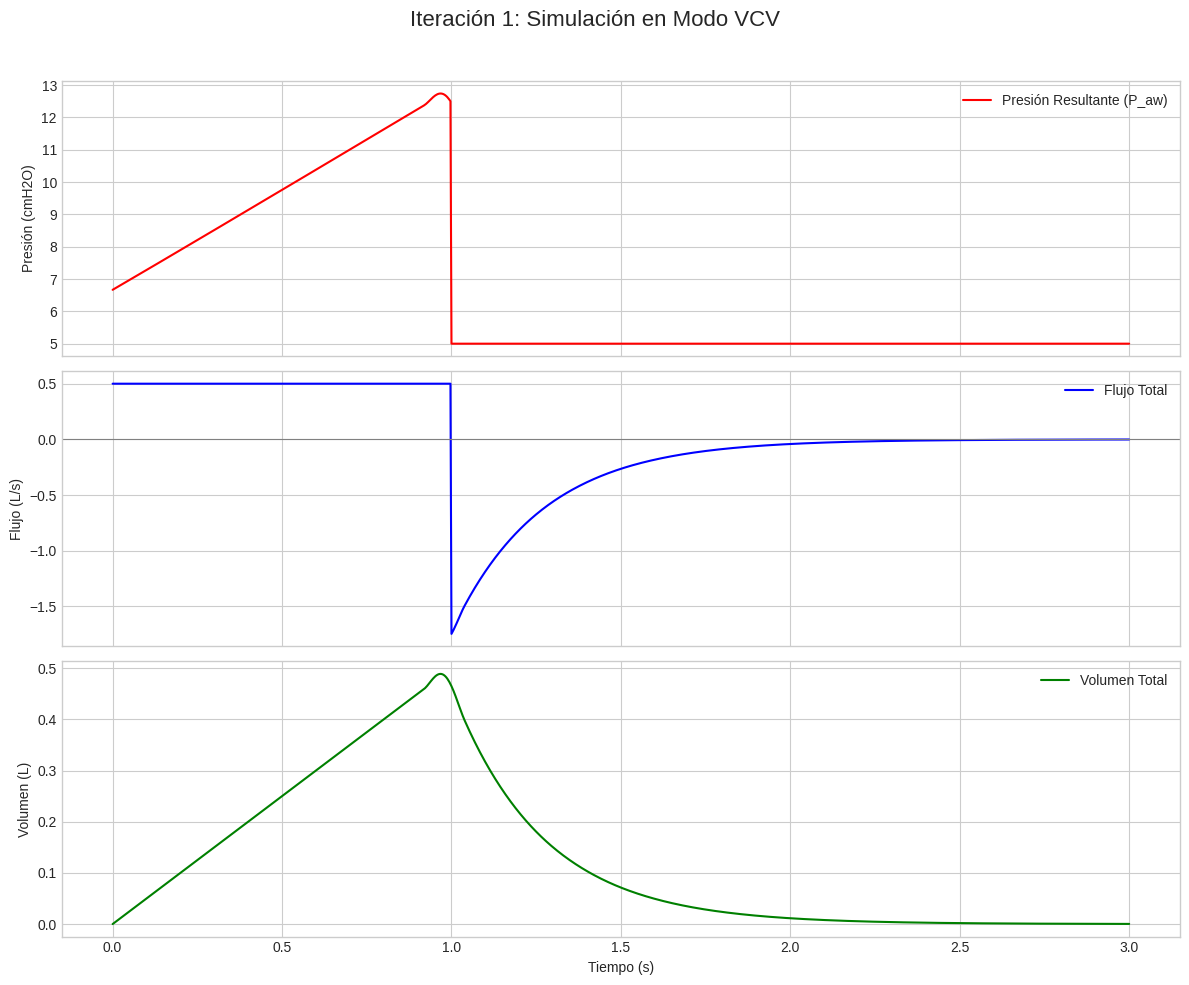

In [9]:
# --- PROCESAMIENTO Y VISUALIZACIÓN DE VCV ---

# Extraer volúmenes
V1_vcv = solucion_vcv.y[0]
V2_vcv = solucion_vcv.y[1]
V_total_vcv = V1_vcv + V2_vcv

# Calcular flujos
flujo1_vcv, flujo2_vcv = modelo_vcv(
    t_eval_vcv, solucion_vcv.y, flujo_inspiratorio_constante, T_insp_vcv, PEEP_vcv, R1, E1, R2, E2
)
flujo_total_vcv = np.array(flujo1_vcv) + np.array(flujo2_vcv)

# Calcular la presión resultante (P_aw) de forma separada para cada fase
# Fase Inspiratoria: P_aw = R*flujo + E*Volumen + PEEP_basal.
# Como el flujo es constante, la presión sube a medida que aumenta el volumen.
P_insp_resistiva = flujo_inspiratorio_constante * (R1*R2 / (R1+R2)) # Resistencia total en paralelo
P_insp_elastica = (E1*V1_vcv + E2*V2_vcv) / 2 # Elastancia promedio ponderada (simplificación)
P_inspiratoria = P_insp_resistiva + P_insp_elastica + PEEP_vcv

# La presión en la vía aérea durante la espiración pasiva es PEEP
P_espiratoria = np.full_like(P_inspiratoria, PEEP_vcv)

# Combinamos las dos fases usando np.where
es_inspiracion = t_eval_vcv < T_insp_vcv
P_resultante_vcv = np.where(es_inspiracion, P_inspiratoria, P_espiratoria)

# --- Gráficos
fig_vcv, axs_vcv = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig_vcv.suptitle('Iteración 1: Simulación en Modo VCV', fontsize=16)

# 1. Gráfica de Presión
axs_vcv[0].plot(t_eval_vcv, P_resultante_vcv, label='Presión Resultante (P_aw)', color='red')
axs_vcv[0].set_ylabel('Presión (cmH2O)')
axs_vcv[0].legend()

# 2. Gráfica de Flujo
axs_vcv[1].plot(t_eval_vcv, flujo_total_vcv, label='Flujo Total', color='blue')
axs_vcv[1].set_ylabel('Flujo (L/s)')
axs_vcv[1].axhline(0, color='grey', linewidth=0.8) # Línea cero
axs_vcv[1].legend()

# 3. Gráfica de Volumen
axs_vcv[2].plot(t_eval_vcv, V_total_vcv, label='Volumen Total', color='green')
axs_vcv[2].set_ylabel('Volumen (L)')
axs_vcv[2].set_xlabel('Tiempo (s)')
axs_vcv[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

En este punto, se puede observa que el comportamiento de las curvas de presión, flujo y volumen, contra tiempo, tanto en VCV como PCV, son relativamente correctos. En ambos, se puede observar el mismo defecto, que es que la presión en la vía aérea nunca cae como un escalón, porque en la medida en que el pulmón se vacia, algo de presión logra mantenerse y cae de una manera mucho más natural, no tan escalonada. Este comportamiento, la caída instantánea y escalonada de la presión, es una limitación inherente al modelo lineal de dos compartimentos que se escogió y no un error de programación, sino una consecuencia directa de las simplificaciones físicas que el modelo asume. La "caída natural" que se puede observar en un paciente real, se debe a fenómenos más complejos que los que el modelo actual incluye:  

1. **Viscoelasticidad**: El tejido pulmonar real no se comporta como un resorte perfecto (puramente elástico). Tiene un componente viscoso, similar a un amortiguador o a la espuma con memoria. Esto significa que:
    * Relajación por estrés (Stress Relaxation): Cuando se insufla un pulmón real y se mantiene el volumen, la presión no se queda fija, sino que decae lentamente a medida que el tejido se "reacomoda".
    * Recoil no instantáneo: Al abrir la válvula espiratoria, esta propiedad viscoelástica hace que la presión caiga de forma suave y no como un escalón instantáneo.  
Este modelo utiliza una elastancia (E) pura, que es la definición de un resorte ideal. Por eso, los cambios de presión son instantáneos.

2. **Inercia del gas**: el modelo actual es de "primer orden":  
$ P = R\dot{V} + EV$
Esto ignora la inercia (masa) de la columna de aire. Un modelo de "segundo orden", más complejo, incluiría un término inercial:
$ P = I \ddot{V} + R \dot{V} + EV $  
Este componente inercial, aunque pequeño en la respiración normal, ayuda a suavizar las transiciones rápidas de flujo.

3. **Comportamiento del ventilador real**: este modelo asume que la válvula espiratoria del ventilador se abre de forma instantánea y perfecta. En la realidad, las válvulas mecánicas tienen un tiempo de apertura de algunos milisegundos, lo que también contribuye a redondear la esquina aguda en la curva de presión.

Como se sustentó en el objetivo 1, desde que se seleccionó el modelo, era claro que tendría limitaciones, pero esas limitaciones se asumieron conscientemente: se sacrificaron algunos detalles finos de la curva, a cambio de claridad pedagógica y simplicidad computacional.  
Hasta este punto, hay un prototipo que funciona, ya en dos modos distintos de ventilación.

## Fisiopatología: paciente con EPOC severo

Es importante recordar que las patologías pulmonares se dividen en 2 grandes grupos:  
* Obstructivas: las que tienen resistencia aumentada.
* Restrictivas: las que tienen distensibilidad disminuída.

Vamos a poner prueba el modelo, con valores extremos, para verificar que sirve también para enseñar la fisiopatología de algunas condiciones médicas.

### Paciente con EPOC severo

La Enfermedad Pulmonar Obstructiva Crónica (EPOC), es una patología obstructiva. Entonces, los parámetros más significativos que debemos modelar son:
1. Resistencia (R) aumentada.
2. Distensibilidad ó *compliance* (C) aumentada: En el EPOC, la destrucción del tejido elástico (enfisema) hace que los pulmones se vuelvan más distensibles. Una distensibilidad aumentada implica una elastancia (E) disminuída.
3. Heterogeneidad: La enfermedad no afecta a todo el pulmón por igual. Se modelará un compartimento muy enfermo (R y C altas) y otro menos afectado.

El resultado de tener R y C altas es una constante de tiempo ($\tau = R \cdot C$) larga, lo que significa que el pulmón tarda mucho tiempo en llenarse y, especialmente, en vaciarse.  
Se definen los nuevos parámetros:

In [10]:
# --- PERFIL DE PACIENTE: EPOC SEVERO ---

R1_epoc = 30     # Resistencia muy alta en el compartimento enfermo (cmH2O/L/s)
C1_epoc = 0.08   # Compliancia alta en el compartimento enfermo (L/cmH2O)
E1_epoc = 1 / C1_epoc

R2_epoc = 10     # Resistencia moderada en el compartimento "mejor"
C2_epoc = 0.05   # Compliancia normal-alta en el compartimento "mejor"
E2_epoc = 1 / C2_epoc

print(f"Constante de tiempo del compartimento 1 (enfermo): {R1_epoc * C1_epoc:.2f} s")
print(f"Constante de tiempo del compartimento 2 ('mejor'): {R2_epoc * C2_epoc:.2f} s")

Constante de tiempo del compartimento 1 (enfermo): 2.40 s
Constante de tiempo del compartimento 2 ('mejor'): 0.50 s


In [11]:
# Solución del modelo en VCV para EPOC
solucion_vcv_epoc = solve_ivp(
    fun=modelo_vcv,
    t_span=[0, T_total_vcv],
    y0=V_inicial_vcv,
    t_eval=t_eval_vcv,
    args=(flujo_inspiratorio_constante, T_insp_vcv, PEEP_vcv, R1_epoc, E1_epoc, R2_epoc, E2_epoc),
    dense_output=True
)

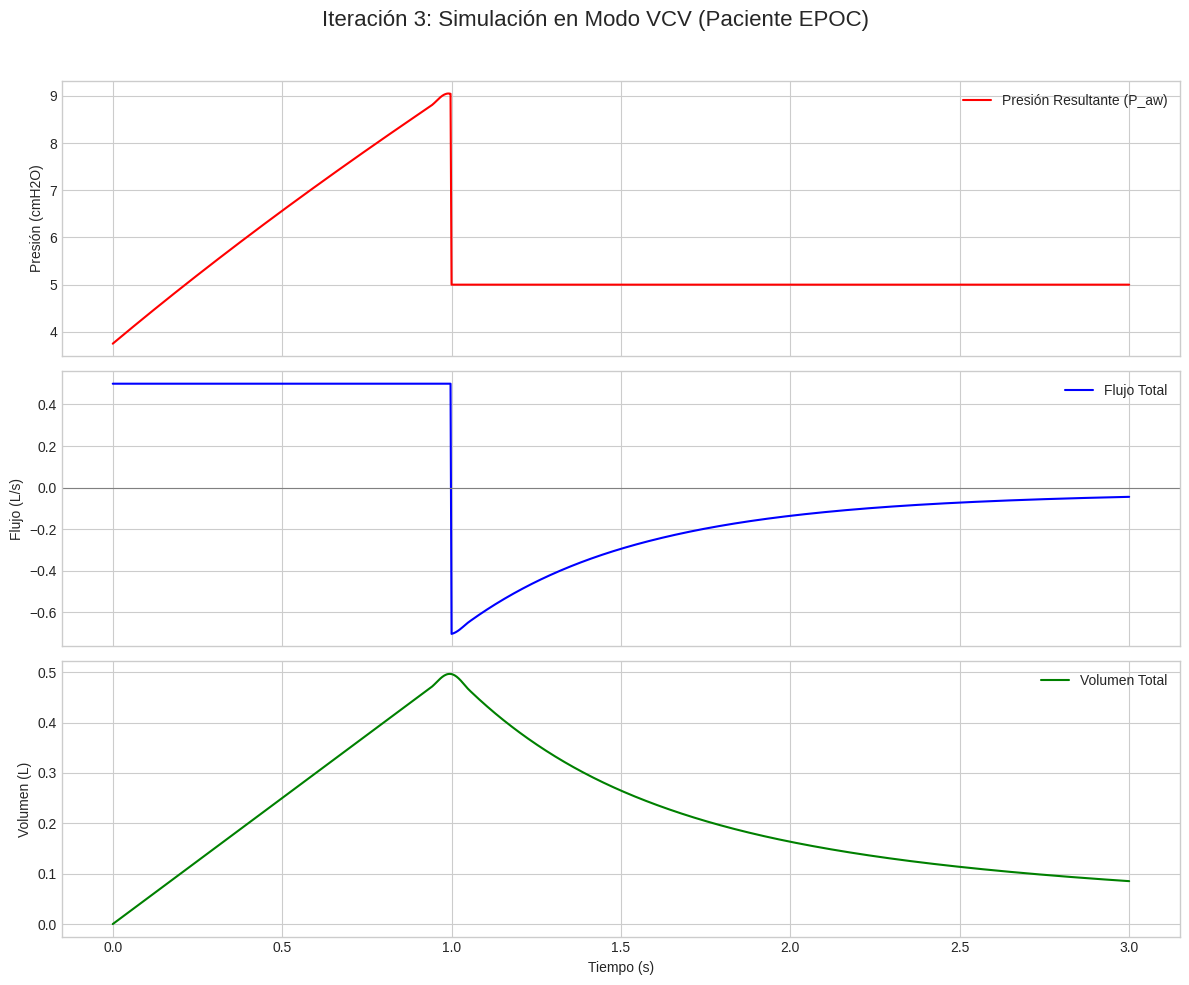

Volumen atrapado al final de la espiración: 0.09 L
Auto-PEEP en compartimento 1: 0.99 cmH2O
Auto-PEEP en compartimento 2: 0.12 cmH2O


In [12]:
# --- PROCESAMIENTO Y VISUALIZACIÓN DE VCV (PACIENTE EPOC) ---

# Extraer volúmenes de la nueva solución
V1_vcv_epoc = solucion_vcv_epoc.y[0]
V2_vcv_epoc = solucion_vcv_epoc.y[1]
V_total_vcv_epoc = V1_vcv_epoc + V2_vcv_epoc

# Calcular flujos usando los parámetros de EPOC
flujo1_vcv_epoc, flujo2_vcv_epoc = modelo_vcv(
    t_eval_vcv, solucion_vcv_epoc.y, flujo_inspiratorio_constante,
    T_insp_vcv, PEEP_vcv, R1_epoc, E1_epoc, R2_epoc, E2_epoc
)
flujo_total_vcv_epoc = np.array(flujo1_vcv_epoc) + np.array(flujo2_vcv_epoc)

# Calcular la curva de presión resultante usando los parámetros de EPOC
def calcular_presion_vcv_epoc(t, V1, V2):
    numerador_insp = flujo_inspiratorio_constante + (E1_epoc * V1 / R1_epoc) + (E2_epoc * V2 / R2_epoc)
    denominador_insp = (1 / R1_epoc) + (1 / R2_epoc)
    P_aw_insp = numerador_insp / denominador_insp

    # Durante la espiración, la presión en la vía aérea es PEEP
    # (la presión alveolar será mayor debido al Auto-PEEP)
    P_espiratoria = PEEP_vcv

    return np.where(t < T_insp_vcv, P_aw_insp, P_espiratoria)

P_resultante_vcv_epoc = calcular_presion_vcv_epoc(t_eval_vcv, V1_vcv_epoc, V2_vcv_epoc)

# --- Gráficos para el paciente con EPOC ---
fig_vcv_epoc, axs_vcv_epoc = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig_vcv_epoc.suptitle('Iteración 3: Simulación en Modo VCV (Paciente EPOC)', fontsize=16)

# 1. Gráfica de Presión
axs_vcv_epoc[0].plot(t_eval_vcv, P_resultante_vcv_epoc, label='Presión Resultante (P_aw)', color='red')
axs_vcv_epoc[0].set_ylabel('Presión (cmH2O)')
axs_vcv_epoc[0].legend()

# 2. Gráfica de Flujo
axs_vcv_epoc[1].plot(t_eval_vcv, flujo_total_vcv_epoc, label='Flujo Total', color='blue')
axs_vcv_epoc[1].set_ylabel('Flujo (L/s)')
axs_vcv_epoc[1].axhline(0, color='grey', linewidth=0.8)
axs_vcv_epoc[1].legend()

# 3. Gráfica de Volumen
axs_vcv_epoc[2].plot(t_eval_vcv, V_total_vcv_epoc, label='Volumen Total', color='green')
axs_vcv_epoc[2].set_ylabel('Volumen (L)')
axs_vcv_epoc[2].set_xlabel('Tiempo (s)')
axs_vcv_epoc[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- CÁLCULO DE AUTO-PEEP ---
V1_final_epoc = V1_vcv_epoc[-1]
V2_final_epoc = V2_vcv_epoc[-1]

auto_peep_c1 = E1_epoc * V1_final_epoc
auto_peep_c2 = E2_epoc * V2_final_epoc

print(f"Volumen atrapado al final de la espiración: {V_total_vcv_epoc[-1]:.2f} L")
print(f"Auto-PEEP en compartimento 1: {auto_peep_c1:.2f} cmH2O")
print(f"Auto-PEEP en compartimento 2: {auto_peep_c2:.2f} cmH2O")

In [13]:
# --- CÁLCULO DE AUTO-PEEP ---
# Obtenemos el volumen final en cada compartimento
V1_final_epoc = solucion_vcv_epoc.y[0][-1]
V2_final_epoc = solucion_vcv_epoc.y[1][-1]

# Calculamos la presión elástica de ese volumen atrapado
auto_peep_c1 = E1_epoc * V1_final_epoc
auto_peep_c2 = E2_epoc * V2_final_epoc

print(f"Volumen atrapado al final de la espiración: {V_total_vcv_epoc[-1]:.2f} L")
print(f"Auto-PEEP en compartimento 1: {auto_peep_c1:.2f} cmH2O")
print(f"Auto-PEEP en compartimento 2: {auto_peep_c2:.2f} cmH2O")

Volumen atrapado al final de la espiración: 0.09 L
Auto-PEEP en compartimento 1: 0.99 cmH2O
Auto-PEEP en compartimento 2: 0.12 cmH2O


Se observa que en un solo ciclo respiratorio, el comportamiento del simulador es adecuado; sin embargo, a lo largo de varios ciclos, no puede atraparse la misma cantidad de aire, porque el resultado sería que en aproximadamente 55 ciclos, el volumen completo del pulmón terminaría atrapado. Hasta ahora sólo se ha simulado un único ciclo respiratorio, partiendo de un pulmón vacío, así que, es hora de hacer una simulación multiciclo, donde las el volumen atrapado y el autopeep resultante, se convierten en las condiciones iniciales del siguiente ciclo, que debe continuar así hasta que el sistema alcance un nuevo equilibro dinámico: el volumen se seguirá acumulando hasta que la presión elástica generada por el volumen atrapado sea tan alta, que logre expulsar durante la espiración, la misma cantidad de aire que entró en la inspiración.

## Simulación de múltiples ciclos

Se va a envolver la simulación en un solo ciclo `for`, pasando las condiciones finales de un ciclo como las condiciones iniciales del siguiente. Hay que modificar el modelo de VCV para poder trabajar con ventanas de tiempo mayores.

In [14]:
def modelo_vcv(t, y, flujo_insp, T_insp, PEEP, R1, E1, R2, E2):
    """
    Versión del modelo VCV que funciona para tiempo contínuo en multi-ciclo.
    """
    V1, V2 = y

    # Lógica Inspiratoria
    numerador_insp = flujo_insp + (E1 * V1 / R1) + (E2 * V2 / R2)
    denominador_insp = (1 / R1) + (1 / R2)
    P_aw_insp = numerador_insp / denominador_insp
    dV1_dt_insp = (P_aw_insp - E1 * V1) / R1
    dV2_dt_insp = (P_aw_insp - E2 * V2) / R2

    # Lógica Espiratoria
    dV1_dt_esp = (-E1 * V1) / R1
    dV2_dt_esp = (-E2 * V2) / R2

    # Determinar la fase del ciclo
    tiempo_en_ciclo = t % T_total_vcv
    es_inspiracion = tiempo_en_ciclo < T_insp

    dV1_dt = np.where(es_inspiracion, dV1_dt_insp, dV1_dt_esp)
    dV2_dt = np.where(es_inspiracion, dV2_dt_insp, dV2_dt_esp)

    return [dV1_dt, dV2_dt]

In [15]:
num_ciclos = 15 # Simulación de 15 respiraciones para ver cómo se estabiliza

tiempos_totales = []
V1_totales = []
V2_totales = []

# La condición inicial para el PRIMER ciclo empieza en cero
V_inicial_ciclo = [0, 0]

In [16]:
# Bucle de múltiples ciclos

for i in range(num_ciclos):
    t_start = i * T_total_vcv
    t_end = (i + 1) * T_total_vcv
    t_span_ciclo = [t_start, t_end]
    t_eval_ciclo = np.linspace(t_start, t_end, 100)

    # Solución del ciclo, con condiciones iniciales actualizadas
    solucion_ciclo = solve_ivp(
        fun=modelo_vcv,
        t_span=t_span_ciclo,
        y0=V_inicial_ciclo, # Condición inicial del ciclo
        t_eval=t_eval_ciclo,
        args=(flujo_inspiratorio_constante, T_insp_vcv, PEEP_vcv, R1_epoc, E1_epoc, R2_epoc, E2_epoc),
        dense_output=True
    )

    # Guardar los resultados
    tiempos_totales.extend(solucion_ciclo.t)
    V1_totales.extend(solucion_ciclo.y[0])
    V2_totales.extend(solucion_ciclo.y[1])

    # Condiciones finales de este ciclo = condiciones iniciales del siguiente
    V_inicial_ciclo = solucion_ciclo.y[:, -1]

# Listas a arreglos de NumPy para poder graficar
tiempos_totales = np.array(tiempos_totales)
V1_totales = np.array(V1_totales)
V2_totales = np.array(V2_totales)

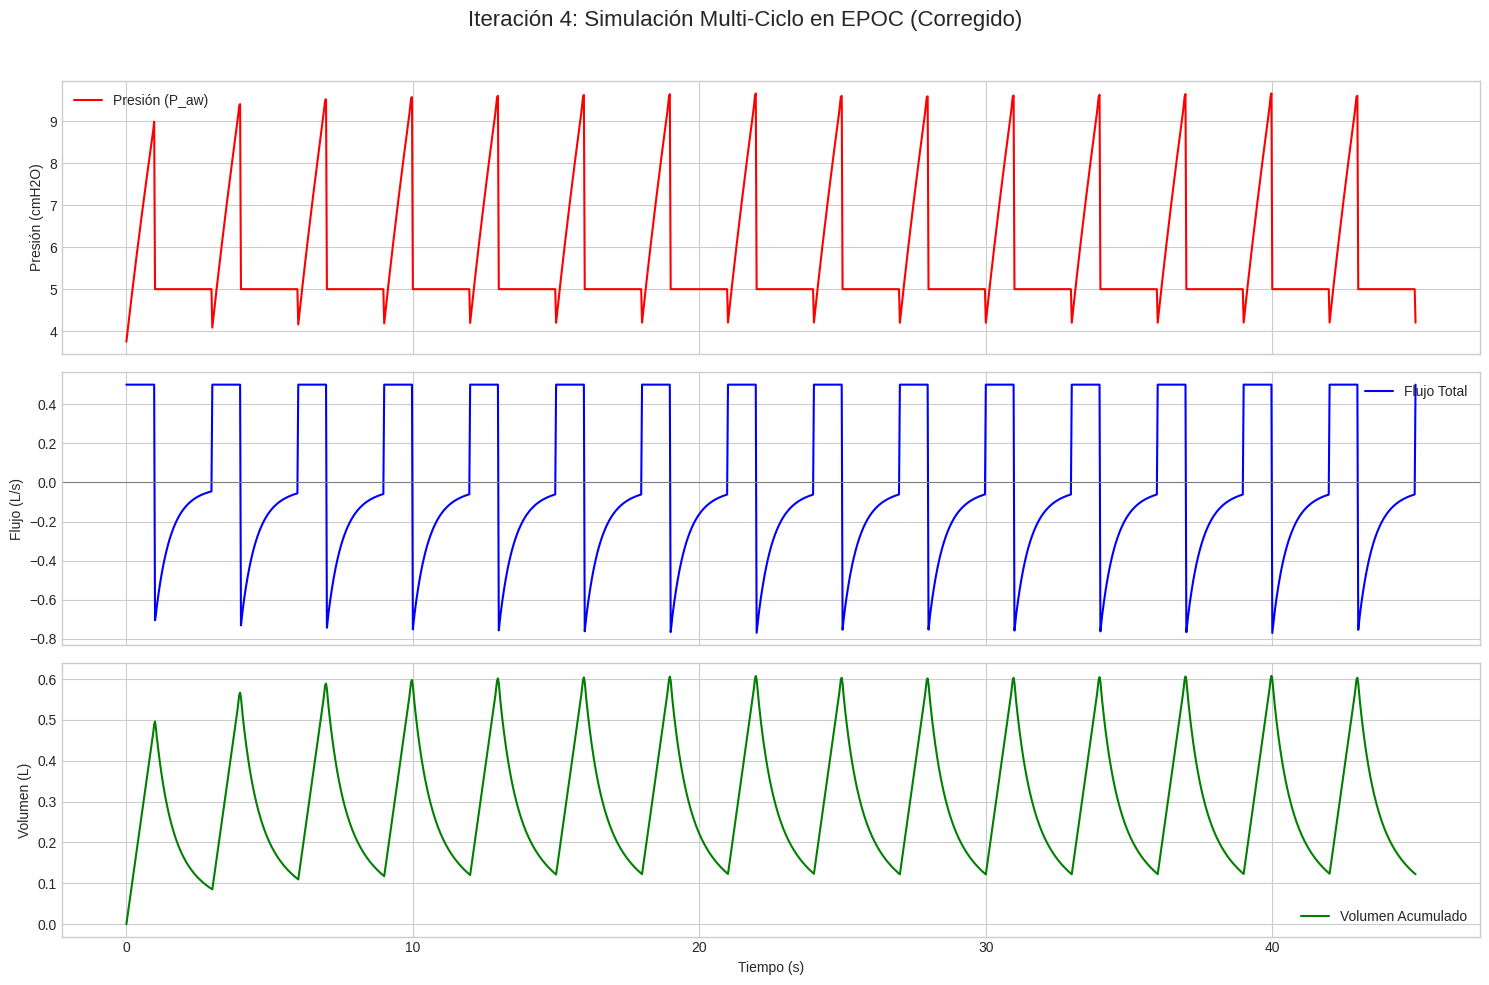

Volumen atrapado final (estable): 0.12 L
Auto-PEEP final (estable): 1.45 cmH2O


In [17]:
# Extraer y calcular volúmenes y flujos
V_total_epoc_multi = V1_totales + V2_totales
flujo1_epoc_multi, flujo2_epoc_multi = modelo_vcv(
    tiempos_totales, np.vstack((V1_totales, V2_totales)), flujo_inspiratorio_constante,
    T_insp_vcv, PEEP_vcv, R1_epoc, E1_epoc, R2_epoc, E2_epoc
)
flujo_total_epoc_multi = np.array(flujo1_epoc_multi) + np.array(flujo2_epoc_multi)

# Función para calcular la presión
def calcular_presion_vcv_epoc(t, V1, V2):
    # Lógica inspiratoria (idéntica a la del modelo_vcv)
    numerador_insp = flujo_inspiratorio_constante + (E1_epoc * V1 / R1_epoc) + (E2_epoc * V2 / R2_epoc)
    denominador_insp = (1 / R1_epoc) + (1 / R2_epoc)
    P_aw_insp = numerador_insp / denominador_insp

    # Lógica espiratoria (la presión en la vía aérea es la PEEP)
    P_espiratoria = PEEP_vcv

    # Para todos los ciclos
    tiempo_en_ciclo = t % T_total_vcv
    es_inspiracion = tiempo_en_ciclo < T_insp_vcv

    return np.where(es_inspiracion, P_aw_insp, P_espiratoria)

# Se llama la función
P_resultante_epoc_multi = calcular_presion_vcv_epoc(tiempos_totales, V1_totales, V2_totales)

# Gráficos
fig_multi, axs_multi = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
fig_multi.suptitle('Iteración 4: Simulación Multi-Ciclo en EPOC (Corregido)', fontsize=16)

# Presión
axs_multi[0].plot(tiempos_totales, P_resultante_epoc_multi, label='Presión (P_aw)', color='red')
axs_multi[0].set_ylabel('Presión (cmH2O)')
axs_multi[0].legend()
# Flujo
axs_multi[1].plot(tiempos_totales, flujo_total_epoc_multi, label='Flujo Total', color='blue')
axs_multi[1].set_ylabel('Flujo (L/s)')
axs_multi[1].axhline(0, color='grey', linewidth=0.8)
axs_multi[1].legend()
# Volumen
axs_multi[2].plot(tiempos_totales, V_total_epoc_multi, label='Volumen Acumulado', color='green')
axs_multi[2].set_ylabel('Volumen (L)')
axs_multi[2].set_xlabel('Tiempo (s)')
axs_multi[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Cálculo de Auto-PEEP
V1_final_multi = V1_totales[-1]
V_total_final_multi = V_total_epoc_multi[-1]
auto_peep_final = E1_epoc * V1_final_multi # Aproximación con el compartimento más enfermo
print(f"Volumen atrapado final (estable): {V_total_final_multi:.2f} L")
print(f"Auto-PEEP final (estable): {auto_peep_final:.2f} cmH2O")